In [15]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath, ufloat_fromstr

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [69]:
coinc_counts = np.loadtxt('../data/gamma2_run3.TKA', unpack=True)
all_counts = np.loadtxt('../data/co57_G20.TKA', unpack=True)
bins = np.arange(0, len(all_counts))
# idx = np.nonzero(coinc_counts)
idx = slice(113, 170)
coinc_counts = coinc_counts[idx]
all_counts = all_counts[idx]
bins = bins[idx]

In [70]:
normalized_all = all_counts / np.sum(all_counts)
normalized_coinc = (coinc_counts / np.sum(coinc_counts) * 0.82)

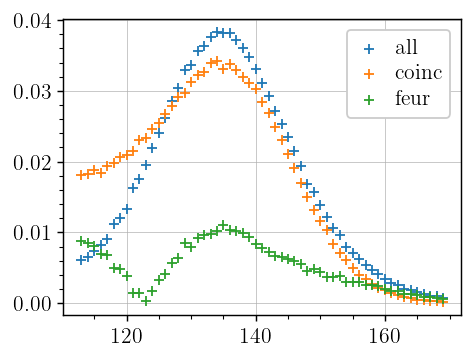

In [71]:
plt.scatter(bins, normalized_all, label='all')
plt.scatter(bins, normalized_coinc/0.82, label='coinc')
plt.scatter(bins, np.abs(normalized_all - normalized_coinc), label='feur')
plt.legend()
# plt.yscale('log')
# plt.xlim(0, 300)

In [6]:
with open('../data/energy_calibration_coefs.csv', 'r') as f:
    s = f.read()
    a, b = s.split(',')
    a = ufloat_fromstr(a)
    b = ufloat_fromstr(b)
fitfunc = np.poly1d([a.n, b.n])

In [7]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x-mu)**2/(2*sigma**2))

In [141]:
gamma3 = (normalized_all - normalized_coinc)

idx = gamma3 > 0
gamma3_filtered = gamma3[idx]
bins_filtered = bins[idx]

g3_idx = slice(0, 1000)
coefs_gamma3, pcov_gamma3 = sc.optimize.curve_fit(
    gauss, bins_filtered[g3_idx], gamma3_filtered[g3_idx],
    p0=(1, 90, 10),
    bounds=((0, 50, 1), (np.inf, 140, np.inf))
)
coefs_err_gamma3 = unp.uarray(coefs_gamma3, np.sqrt(np.diag(pcov_gamma3)))
g2_idx = slice(10, 70)
coefs_gamma2, pcov_gamma2 = sc.optimize.curve_fit(
    gauss, bins[g2_idx], normalized_coinc[g2_idx],
    p0=(1, 90, 10),
    bounds=((0, 50, 1), (np.inf, 140, np.inf))
)
coefs_err_gamma2 = unp.uarray(coefs_gamma2, np.sqrt(np.diag(pcov_gamma2)))

print("Energy gamma3", energy_gamma3 := a*coefs_err_gamma3[1] + b, 'sigma', coefs_err_gamma3[2])
print("Energy gamma2", energy_gamma2 := a*coefs_err_gamma2[1] + b, 'sigma', coefs_err_gamma2[2])

Energy gamma3 126+/-24 sigma 10.2+/-0.5
Energy gamma2 122+/-23 sigma 11.13+/-0.11


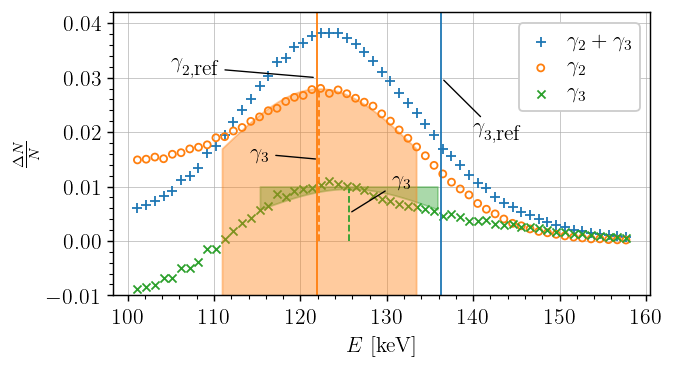

In [149]:
p = plt.rcParams
p["figure.figsize"] = (14*INCH_PER_CM, 7*INCH_PER_CM) # a bit less than half \textwidth
p['savefig.bbox'] = 'standard'
p["figure.subplot.left"]   = 0.23
p['figure.subplot.right']  = 0.98
p['figure.subplot.top']    = 0.97
p['figure.subplot.bottom'] = 0.18

plt.scatter(fitfunc(bins), normalized_all, label=r'$\gamma_2+\gamma_3$')
plt.scatter(fitfunc(bins), normalized_coinc, marker='o', s=15, facecolors='none', edgecolors='C1', label=r'$\gamma_2$')
plt.scatter(fitfunc(bins), gamma3, marker='x', s=20, color='C2', label=r'$\gamma_3$')
x = np.linspace(bins.min(), bins.max(), 100)
# plt.plot(fitfunc(x), gauss(x, *coefs_gamma3), color='C2')
# plt.plot(fitfunc(x), gauss(x, *coefs_gamma2), color='C1')

# plt.axvline(fitfunc(coefs_gamma3[1]))
x = np.linspace(coefs_err_gamma3[1].n - coefs_err_gamma3[2].n, coefs_err_gamma3[1].n + coefs_err_gamma3[2].n)
plt.fill_between(fitfunc(x), 0.01, gauss(x, *coefs_gamma3), color='C2', alpha=0.4)
plt.vlines(fitfunc(coefs_gamma3[1]), 0, gauss(coefs_gamma3[1], *coefs_gamma3), color='C2', ls='--')

x = np.linspace(coefs_err_gamma2[1].n - coefs_err_gamma2[2].n, coefs_err_gamma2[1].n + coefs_err_gamma2[2].n)
plt.fill_between(fitfunc(x), -0.01, gauss(x, *coefs_gamma2), color='C1', alpha=0.4, interpolate=True)
plt.vlines(fitfunc(coefs_gamma2[1]), 0, gauss(coefs_gamma2[1], *coefs_gamma2), color='C1', ls='--')

plt.axvline(136.3, color='C0')
plt.axvline(121.9, color='C1')
plt.annotate(r'$\gamma_{3,\textrm{ref}}$', (136.3, 0.03), (140, 0.02), arrowprops=dict(arrowstyle="-", lw=0.75))
plt.annotate(r'$\gamma_{2,\textrm{ref}}$', (121.9, 0.03), (105, 0.032), arrowprops=dict(arrowstyle="-", lw=0.75))

plt.annotate(r'$\gamma_{3}$', (energy_gamma3.n, 0.005), (energy_gamma3.n + 5, 0.01), arrowprops=dict(arrowstyle="-", lw=0.75))
plt.annotate(r'$\gamma_{3}$', (energy_gamma2.n, 0.015), (energy_gamma2.n - 8, 0.015), arrowprops=dict(arrowstyle="-", lw=0.75))

plt.ylim(-0.01, 0.042)
plt.xlabel(r'$E$ [keV]')
plt.ylabel(r'$\frac{\Delta N}{N}$')
plt.legend()
plt.savefig('../figures/co57_gamma2_gamma3.pdf')

In [144]:
abs(energy_gamma3.n - 136.3)/136.3

0.07860614551596824

In [145]:
abs(energy_gamma2.n - 121.9)/121.9

0.002133415657636093